# 4.2 Explanation Selectivity

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_4_2 import MNIST_CNN, MNIST_DNN, Taylor
from utils import find_roi

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/4_2_ES/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('ES', logits)
    tf.add_to_collection('ES', X)
    
    for activation in activations:
        tf.add_to_collection('ES', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.225782401 accuracy = 0.929563641
Epoch: 0002 cost = 0.065556036 accuracy = 0.979272737
Epoch: 0003 cost = 0.045941221 accuracy = 0.986109102
Epoch: 0004 cost = 0.034556200 accuracy = 0.989072737
Epoch: 0005 cost = 0.027639251 accuracy = 0.991200008
Epoch: 0006 cost = 0.023350651 accuracy = 0.992272734
Epoch: 0007 cost = 0.018475145 accuracy = 0.994400005
Epoch: 0008 cost = 0.015939257 accuracy = 0.995127277
Epoch: 0009 cost = 0.013538822 accuracy = 0.995600004
Epoch: 0010 cost = 0.011767525 accuracy = 0.996236367
Epoch: 0011 cost = 0.011445093 accuracy = 0.996309094
Epoch: 0012 cost = 0.009868789 accuracy = 0.996727276
Epoch: 0013 cost = 0.008303729 accuracy = 0.997127275
Epoch: 0014 cost = 0.009200275 accuracy = 0.996872730
Epoch: 0015 cost = 0.006096579 accuracy = 0.997945457
Accuracy: 0.9931


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

INFO:tensorflow:Restoring parameters from ./tf_logs/4_2_ES/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [5]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

activations = tf.get_collection('ES')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='CNN')

logits = activations[0]
X = activations[1]
activations = activations[1:]

taylor = Taylor(activations, weights, conv_ksize, pool_ksize, conv_strides, pool_strides, 'Taylor')

Rs = [taylor(i) for i in range(10)]

SA_scores = tf.square(tf.gradients(logits, X))
STD_scores = tf.negative(tf.gradients(logits, X) * X)

### 6. Calculating Relevance Scores $R(x_i)$ and Displaying Images

In [6]:
images = mnist.train.images
labels = mnist.train.labels
sample_imgs = [images[np.argmax(labels, axis=1) == i][5] for i in range(10)]

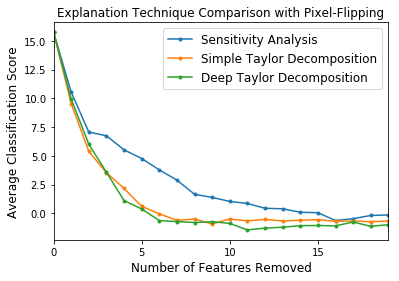

In [7]:
inds = list(range(10))
ksize = [4, 4]
itr = 20

sa_hmaps = []
sa_logs = []
sa_imgs = []

std_hmaps = []
std_logs = []
std_imgs = []

dtd_hmaps = []
dtd_logs = []
dtd_imgs = []

for ind in inds:
    sa_img = [sample_imgs[ind]]
    sa_coords = []
    sa_hmap = []
    sa_log = []
    
    std_img = [sample_imgs[ind]]
    std_coords = []
    std_hmap = []
    std_log = []
    
    dtd_img = [sample_imgs[ind]]
    dtd_coords = []
    dtd_hmap = []
    dtd_log = []

    for i in range(itr):
        sa_lg, sa_res = sess.run([logits[:,ind], SA_scores], feed_dict={X: sa_img[-1][None,:]})
        std_lg, std_res = sess.run([logits[:,ind], STD_scores], feed_dict={X: std_img[-1][None,:]})
        dtd_lg, dtd_res = sess.run([logits[:,ind], Rs[ind]], feed_dict={X: dtd_img[-1][None,:]})
        
        sa_hmap.append(sa_res[0].reshape(784))
        sa_log.append(sa_lg.reshape([]))
        
        std_hmap.append(std_res.reshape(784))
        std_log.append(std_lg.reshape([]))
        
        dtd_hmap.append(dtd_res.reshape(784))
        dtd_log.append(dtd_lg.reshape([]))

        sa_coord = find_roi(np.square(sa_res[0]).reshape(28,28), ksize, sa_coords)
        sa_coords.append(sa_coord)
        
        std_coord = find_roi(std_res.reshape(28,28), ksize, std_coords)
        std_coords.append(std_coord)
        
        dtd_coord = find_roi(dtd_res.reshape(28,28), ksize, dtd_coords)
        dtd_coords.append(dtd_coord)
        
        if i is itr - 1:
            break

        temp = np.copy(sa_img[-1])
        temp = temp.reshape(28,28) 
        temp[sa_coord[0]:sa_coord[0]+ksize[0], sa_coord[1]:sa_coord[1]+ksize[1]].fill(0)
        sa_img.append(temp.reshape(784))
        
        temp = np.copy(std_img[-1])
        temp = temp.reshape(28,28) 
        temp[std_coord[0]:std_coord[0]+ksize[0], std_coord[1]:std_coord[1]+ksize[1]].fill(0)
        std_img.append(temp.reshape(784))
        
        temp = np.copy(dtd_img[-1])
        temp = temp.reshape(28,28) 
        temp[dtd_coord[0]:dtd_coord[0]+ksize[0], dtd_coord[1]:dtd_coord[1]+ksize[1]].fill(0)
        dtd_img.append(temp.reshape(784))
    
    sa_hmaps.append(sa_hmap)
    sa_logs.append(sa_log)
    sa_imgs.append(sa_img)
    
    std_hmaps.append(std_hmap)
    std_logs.append(std_log)
    std_imgs.append(std_img)
    
    dtd_hmaps.append(dtd_hmap)
    dtd_logs.append(dtd_log)
    dtd_imgs.append(dtd_img)

fig = plt.figure()
ax = fig.add_subplot(111)

x = list(range(itr))
y1 = np.average(sa_logs, axis=0)
y2 = np.average(std_logs, axis=0)
y3 = np.average(dtd_logs, axis=0)

ax.plot(x,y1, label='Sensitivity Analysis', marker='.')
ax.plot(x,y2, label='Simple Taylor Decomposition', marker='.')
ax.plot(x,y3, label='Deep Taylor Decomposition', marker='.')
ax.set_xbound(0, 19)
# ax.set_ybound(0)
ax.set_title('Explanation Technique Comparison with Pixel-Flipping', fontdict={'fontsize': 12})
ax.set_xlabel('Number of Features Removed', fontdict={'fontsize': 12})
ax.set_ylabel('Average Classification Score', fontdict={'fontsize': 12})

ax.set_xticks(list(range(0, 20, 5)))

ax.legend(fontsize='large')

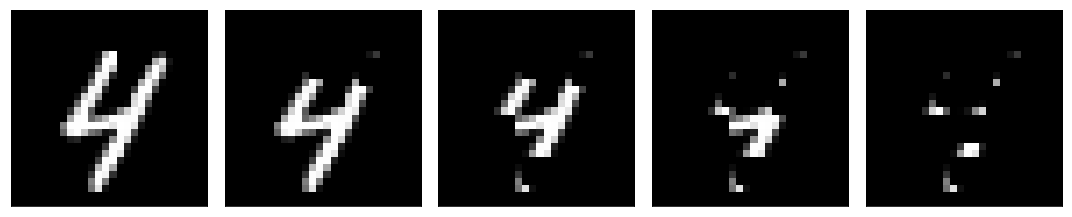

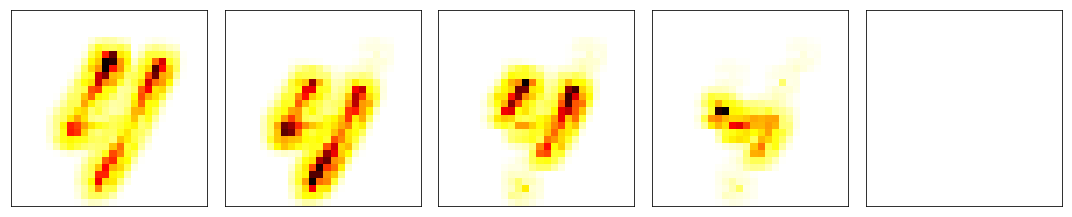

In [8]:
digit = 4

fig = plt.figure(figsize=[15,15])
for i in range(5):      
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(dtd_imgs[digit][i * 2].reshape([28,28]), cmap='gray')
    ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
plt.tight_layout()

fig = plt.figure(figsize=[15,15])
for i in range(5):      
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(dtd_hmaps[digit][i * 2].reshape([28,28]), cmap='hot_r')
    ax.tick_params(labelbottom='off', labelleft='off', bottom='off', left='off')
plt.tight_layout()